Epoch 0
-------------------------------
Epoch 1000
-------------------------------
Epoch 2000
-------------------------------
Epoch 3000
-------------------------------
Epoch 4000
-------------------------------
Epoch 5000
-------------------------------
Epoch 6000
-------------------------------
Epoch 7000
-------------------------------
Epoch 8000
-------------------------------
Epoch 9000
-------------------------------
Epoch 10000
-------------------------------
Epoch 11000
-------------------------------
Epoch 12000
-------------------------------
Epoch 13000
-------------------------------
Epoch 14000
-------------------------------
Epoch 15000
-------------------------------
Epoch 16000
-------------------------------
Epoch 17000
-------------------------------
Epoch 18000
-------------------------------
Epoch 19000
-------------------------------


Loss         Accuracy          Epoch
                          Train    Test    Train    Test       
@ Lowest Test Loss       0.0717  0.0290   0.7941  0.8571  15563
@ Highest Test Accuracy  0.0683  0.0359   0.6471  0.8857   5880

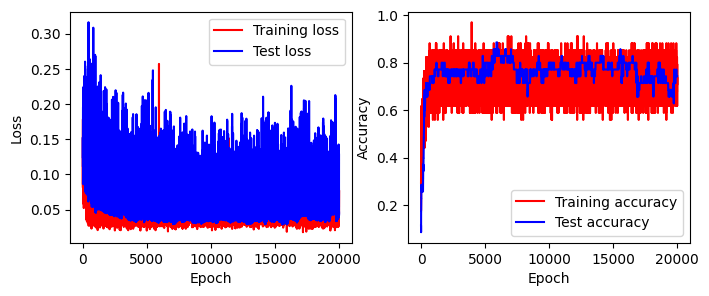

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim.sparse_adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# seed = np.random.randint(10000)
# print("Seed: %d" % seed)
seed = 985  # num_experts=3, top_k=2
# seed = 8689 # num_experts=3, top_k=3
torch.manual_seed(seed)

import matplotlib.pyplot as plt

# Step 1: Load the microarray data
X = pd.read_csv("./datasets/pp5i_train.gr.csv").set_index("SNO").rename_axis(None, axis=0)
mapping = {'MED': 0, 'RHB': 1, 'EPD': 2, 'MGL': 3, 'JPA': 4}
y = pd.read_csv("./datasets/pp5i_train_class.txt").set_index(X.T.index).apply(lambda x: mapping[x['Class']], axis=1)

# Step 2: Clipping the data 
# because the datasets was processed with MAS-4 software which generate negative values,
# and values below 100 are less reproducible and above 16,000 tend to have non-linear correlation with the actual gene expression.
# For dataset with more noise, lower bound of 100 is used.
X_clipped = X.copy().clip(20, 16000)

# Step 3: Filter genes based on maximum-to-minimum ratio
# because many genes are not vary enough to be informative.
X_filtered = X_clipped.copy()
ratio = X_filtered.max(axis=1) / X_filtered.min(axis=1)
X_filtered = X_filtered[ratio > 2]

# Step 4: Transforming the data with log2 
# because the assumption is that
# genes with high values tend to have a higher variance
# while genes with low values tend to have lower variance.
# This makes it difficult to compare genes 
# because the variance depends on the values level.
# Log2 makes the variance uniform across different values level.
X_log2 = X_filtered.copy().astype(float).apply(lambda x: np.log2(x + 1))

# Step 5: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered.T, y, test_size=0.5,
                                                    stratify=y, random_state=42)

# Step 6: Standardize the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# Step 7: Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train_scaled.values, dtype=torch.float32), 
                              torch.tensor(y_train.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test_scaled.values, dtype=torch.float32),
                            torch.tensor(y_test.values, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Define the Expert Network
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc = nn.Linear(input_dim, output_dim)
      self.dropout = nn.Dropout(0.7)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = torch.relu(self.fc(x))
      # Apply dropout
      # to prevent the model from overfitting
      x = self.dropout(x)
      return x

# Define the Gating Network
class Router(nn.Module):
    def __init__(self, input_dim, num_experts):
      super().__init__()
      self.fc = nn.Linear(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, num_experts]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.fc(x)
      if self.training:
        # Add noise to the logits drawn from a normal distribution with mean 0 and variance 0.1
        # to encourage the model to use all the experts.
        x += torch.randn_like(x) * (0.1**0.5) 
      return x

def topk(router_logits: torch.Tensor, top_k: int, dim: int, expert_capacity: int) -> tuple[torch.Tensor, torch.Tensor]:
  """
  router_logits: [batch_size, num_experts]

  torch.topk with `expert_capacity` constraint.
  Suppose each expert can be used at most 2 times in a batch and 
  torch.topk use an `Expert` 3 times in a batch.
  We will replace the 3rd usage of the expert with the next best expert for the sample.
  """
  batch_size = router_logits.size(0)
  num_experts = router_logits.size(1)
  
  sorted_indices = torch.argsort(router_logits, dim=dim, descending=True)
  topk_logits, topk_indices = torch.topk(router_logits, top_k, dim=dim) # [batch_size, top_k]
  new_logits, new_indices = topk_logits.clone(), topk_indices.clone()

  expert_assigned = torch.zeros(num_experts)
  for i in range(batch_size):
    if (expert_assigned == expert_capacity).sum() == num_experts: # expert_capacity is full
      new_logits[i] = 0
      new_indices[i] = -1
      continue

    for j in range(top_k):
      expert_index = sorted_indices[i, j]
      if expert_assigned[expert_index] < expert_capacity:
        expert_assigned[expert_index] += 1
        continue

      for next_expert_index in sorted_indices[i, j:]:
        if expert_assigned[next_expert_index] == expert_capacity: # expert_capacity is full
          continue

        if next_expert_index in new_indices[i]: # prevent duplicate
          continue

        new_logits[i, j] = router_logits[i, next_expert_index]
        new_indices[i, j] = next_expert_index
        expert_assigned[next_expert_index] += 1
        break
  
  return new_logits, new_indices

# Define the MoE Model
class MoE(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, num_experts: int, top_k: int):
      super().__init__()
      self.input_dim = input_dim
      self.output_dim = output_dim
      self.num_experts = num_experts
      self.top_k = top_k
      
      # Create the experts
      self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])

      # Create the router
      self.router = Router(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, output_dim]
    # Note: The gradients are computed 
    # based on how much each expert's output contribution to the loss.
    # If the an expert is used only once for a specific sample,
    # it will receive a gradient based only on that single sample's contribution
    # to the overall loss.
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
      batch_size = x.size(0)

      # Get router logts
      router_logits: torch.Tensor = self.router(x) # [batch_size, num_experts]

      # Get the top-k expert indices for each sample in the batch
      expert_capacity = int(batch_size * self.top_k / self.num_experts)
      if self.training:
        topk_logits, topk_indices = topk(router_logits, self.top_k, dim=-1, expert_capacity=expert_capacity)
      else:
        topk_logits, topk_indices = torch.topk(router_logits, self.top_k, dim=-1)

      weighted_outputs = torch.zeros(self.num_experts, batch_size, self.output_dim)
      for i, expert in enumerate(self.experts):
        expert_mask = (topk_indices == i).any(dim=-1) # [top_k]
        expert_logits = topk_logits[topk_indices == i]

        if expert_mask.any():
          expert_input = x[expert_mask]
          expert_output = expert(expert_input)

          weighted_output = expert_output * expert_logits.unsqueeze(-1)

          weighted_outputs[i][expert_mask] += weighted_output

      return weighted_outputs, router_logits, topk_indices

# [batch_size, num_experts] -> [1]
def load_balancing_loss_fn(router_logits: torch.Tensor) -> torch.Tensor:
  """
  If the sum of the router logits is not balanced across the experts,
  the standard deviation of the sum will be high.
  If the sum of the router logits is balanced across the experts,
  the standard deviation of the sum will be low.
  """
  return router_logits.sum(0).std(0)

# [num_experts, batch_size, output_dim], [batch_size, output_dim] -> [1]
def contrastive_loss(weighted_outputs: torch.Tensor, topk_indices: torch.Tensor) -> torch.Tensor:
  """
  If the output of the experts is similar, the contrastive loss will be low.

  Expected cases:
  1. Within a batch, a sample may be processed by n experts,
  the other samples may be processed by m experts.

  3 experts:
  1. $D_{KL}(p_0||p_1)$, $D_{KL}(p_1||p_0)$
  2. $D_{KL}(p_0||p_2)$, $D_{KL}(p_2||p_0)$
  3. $D_{KL}(p_1||p_2)$, $D_{KL}(p_2||p_1)$

  """
  num_experts = weighted_outputs.size(0)
  kl_div_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
  
  loss = 0
  for i in range(num_experts):
    for j in range(i+1, num_experts):
      # Version A: Assumption that each expert is guaranteed to process each sample
      # p = torch.log_softmax(weighted_outputs[i], dim=-1)
      # q = torch.log_softmax(weighted_outputs[j], dim=-1)
      # d_kl_pq = kl_div_loss(p, q)
      # d_kl_qp = kl_div_loss(q, p)
      # loss += d_kl_pq + d_kl_qp

      # Version B: Assumption that each expert is not guaranteed to process each sample
      # Initialize a mask to ignore samples that are not processed by both experts
      mask = (topk_indices == i).any(dim=-1) & (topk_indices == j).any(dim=-1)
      if mask.any():
        p = torch.log_softmax(weighted_outputs[i][mask], dim=-1)
        q = torch.log_softmax(weighted_outputs[j][mask], dim=-1)
        d_kl_pq = kl_div_loss(p, q)
        d_kl_qp = kl_div_loss(q, p)
        loss += d_kl_pq + d_kl_qp

  return loss

class EarlyStopper:
  """
  Reference:
  https://stackoverflow.com/a/73704579/13285583
  """
  def __init__(self, count_threshold: int, value_delta_threshold: int, goal: str):
    self.count_threshold = count_threshold
    self.value_delta_threshold = value_delta_threshold
    self.counter = 0
    self.goal = goal
    if self.goal == "minimize":
      self.best_score = float('inf')
    elif self.goal == "maximize":
      self.best_score = float('-inf')
    else:
      raise ValueError("mode should be 'minimize' or 'maximize'")

  def __call__(self, score: float):
    if self.goal == "minimize":
      if score < self.best_score:
        self.best_score = score
        self.counter = 0
      elif score - self.best_score > self.value_delta_threshold:
        self.counter += 1
        if self.counter >= self.count_threshold:
          return True
    elif self.goal == "maximize":
      if score > self.best_score:
        self.best_score = score
        self.counter = 0
      elif self.best_score - score > self.value_delta_threshold:
        self.counter += 1
        if self.counter >= self.count_threshold:
          return True
    return False

# Training the MoE model
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer) -> torch.Tensor:
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  avg_loss, avg_accuracy = 0, 0

  model.train()
  for _, (X, y) in enumerate(dataloader):
    weighted_outputs, router_logits, topk_indices = model(X)
    pred = weighted_outputs.sum(0)
    loss: torch.Tensor = loss_fn(pred, y)
    loss += load_balancing_loss_fn(router_logits) * 1e-2
    loss += contrastive_loss(weighted_outputs, topk_indices) * 1e-4
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    avg_loss += loss.item()
    avg_accuracy += (pred.argmax(-1) == y).sum().item()

  # loss, current = loss.item(), batch_index * batch_size + len(X)
  # print(f"loss: {loss:>7f} [{current:>2d}/{size:>2d}]")

  avg_loss /= batch_size
  avg_accuracy /= size

  return avg_loss, avg_accuracy

# Evaluate the MoE model
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> torch.Tensor:
  model.eval()
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  avg_loss, avg_accuracy = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      weighted_outputs, _, topk_indices = model(X)
      pred = weighted_outputs.sum(0)
      loss = loss_fn(pred, y)
      loss += contrastive_loss(weighted_outputs, topk_indices) * 1e-4
      avg_loss += loss.item()
      avg_accuracy += (pred.argmax(-1) == y).sum().item()
  
  avg_accuracy /= size
  avg_loss /= batch_size
  # print(f'Test Error: \n Accuracy: {100 * correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

  return avg_loss, avg_accuracy

# Instantiate the MoE model
_, n_features = X_train.shape
model = MoE(input_dim=n_features, output_dim=5, num_experts=3, top_k=2)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

epochs = 20000
train_losses, train_accuracies = np.zeros(epochs), np.zeros(epochs)
test_losses, test_accuracies = np.zeros(epochs), np.zeros(epochs)
best_test_accuracy = 0
early_stopping = EarlyStopper(count_threshold=5, value_delta_threshold=5e-1, goal="maximize")
for t in range(epochs):
  if t % 1000 == 0:
    print(f"Epoch {t}\n-------------------------------")
  train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer) # Train the model
  train_losses[t] = train_loss
  train_accuracies[t] = train_accuracy
  test_loss, test_accuracy = test_loop(val_loader, model, loss_fn) # Evaluate the model on the validation set
  test_losses[t] = test_loss
  test_accuracies[t] = test_accuracy

  # Save the best model
  if best_test_accuracy < test_accuracy:
    torch.save(model.state_dict(), "model_weights_1_3_2.pth")
    best_test_accuracy = test_accuracy
  
  # Early stopping
  if early_stopping(test_accuracy):
    train_losses, train_accuracies = train_losses[:t+1], train_accuracies[:t+1]
    test_losses, test_accuracies = test_losses[:t+1], test_accuracies[:t+1]
    break

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(range(t+1), train_losses, 'r', label='Training loss')
plt.plot(range(t+1), test_losses, 'b', label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(t+1), train_accuracies, 'r', label='Training accuracy')
plt.plot(range(t+1), test_accuracies, 'b', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

display(pd.DataFrame({("Loss", "Train"):      [train_losses[test_losses.argmin()].round(4), train_losses[test_accuracies.argmax()].round(4)],
                      ("Loss", "Test"):       [test_losses.min().round(4), test_losses[test_accuracies.argmax()].round(4)],
                      ("Accuracy", "Train"):  [train_accuracies[test_losses.argmin()].round(4), train_accuracies[test_accuracies.argmax()].round(4)],
                      ("Accuracy", "Test"):   [test_accuracies[test_losses.argmin()].round(4), test_accuracies.max().round(4)],
                      ("Epoch", ""):          [test_losses.argmin(), test_accuracies.argmax()]},
                     index=["@ Lowest Test Loss", "@ Highest Test Accuracy"]))

In [2]:
# Evaluation Results
model = MoE(input_dim=n_features, output_dim=5, num_experts=3, top_k=2)
model.load_state_dict(torch.load('model_weights_1_3_2.pth', weights_only=True))

X_combined = torch.cat([train_dataset.tensors[0], val_dataset.tensors[0]], dim=0)
y_combined = torch.cat([train_dataset.tensors[1], val_dataset.tensors[1]], dim=0)
combined_dataset = TensorDataset(X_combined, y_combined)
combined_loader = DataLoader(combined_dataset, batch_size=69, shuffle=True)

test_loop(train_loader, model, loss_fn), test_loop(val_loader, model, loss_fn), test_loop(combined_loader, model, loss_fn)

((0.0022400948182621505, 1.0),
 (0.0368943358771503, 0.8857142857142857),
 (0.007240567950234897, 0.9420289855072463))